In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import csv
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.model_selection import KFold, ShuffleSplit, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
raw_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
raw_test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
raw_df.head(20)
raw_df.columns

Index(['addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft',
       'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat',
       'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway',
       'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher',
       'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer',
       'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
       'has_childrens_playroom', 'rent', 'no_fee', 'description',
       'neighborhood', 'borough', 'unit', 'floornumber', 'line'],
      dtype='object')

## Data Explore

In [3]:
raw_df.describe()

,building_id,bedrooms,bathrooms,size_sqft,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,...,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,floornumber
count,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,1.199900e+04,1.200000e+04,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,10723.000000
mean,1.529133e+06,1.657667,1.239500,850.465750,10682.779667,40.727507,-73.956837,2.370093e+06,2.287120e+09,10.266608,...,0.271667,0.170000,0.264083,0.208583,0.073167,0.132083,0.090500,3605.762917,0.490000,6.182738
std,4.301123e+06,1.079771,0.560208,515.773101,593.370964,0.053241,0.043024,1.242919e+06,1.202105e+09,12.019787,...,0.444837,0.375648,0.440862,0.406313,0.260421,0.338595,0.286909,2897.069446,0.499921,7.671545
min,7.300000e+01,0.000000,0.000000,0.000000,10001.000000,40.573898,-74.141570,1.000000e+06,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1250.000000,0.000000,0.000000
25%,6.209200e+04,1.000000,1.000000,610.000000,10023.000000,40.693256,-73.986076,1.052139e+06,1.011220e+09,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2250.000000,0.000000,2.000000
50%,2.495815e+05,2.000000,1.000000,800.000000,11103.000000,40.729028,-73.961700,3.019358e+06,3.006580e+09,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2900.000000,0.000000,3.000000
75%,8.225132e+05,2.000000,1.000000,1000.000000,11218.000000,40.764599,-73.936663,3.326098e+06,3.050580e+09,12.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3900.000000,1.000000,6.000000
max,1.877210e+07,8.000000,20.000000,10000.000000,11694.000000,40.909842,-73.730550,5.158986e+06,5.010640e+09,90.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50000.000000,1.000000,78.000000


In [4]:
raw_df.shape

(12000, 38)

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 7236931 to 7422694
Data columns (total 38 columns):
addr_unit                 11909 non-null object
building_id               12000 non-null int64
bedrooms                  12000 non-null int64
bathrooms                 12000 non-null float64
size_sqft                 12000 non-null float64
created_at                12000 non-null object
addr_street               12000 non-null object
addr_city                 12000 non-null object
addr_zip                  12000 non-null int64
addr_lat                  12000 non-null float64
addr_lon                  12000 non-null float64
bin                       11999 non-null float64
bbl                       12000 non-null int64
floor_count               12000 non-null float64
year_built                11597 non-null float64
min_to_subway             11874 non-null float64
has_doorman               12000 non-null int64
has_elevator              12000 non-null int64
has_fireplace    

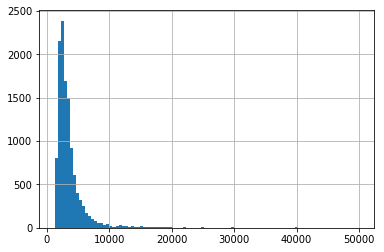

In [6]:
raw_df['rent'].hist(bins=100)

### Seperate all features into continuous, categorical and binary features.

For those none relatived features as below, we have excluded them from the features grouping: 
- addr_unit: no relationship
- building_id: no relationship
- addr_lat: hard to analyze latitude
- addr_lon: hard to analyze longtitude
- bin: no relationship
- bbl: no relationshio
- description: hard to build a NLP model
- unit: no relationship


In [7]:
continuous_features =['bathrooms','bedrooms','size_sqft','floor_count','year_built','min_to_subway','floornumber' ]
caterigal_features =['addr_street','addr_city','addr_zip','neighborhood','borough','line' ]
binary_features = ['has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher','is_furnished', 'has_gym', 'allows_pets', 
                   'has_washer_dryer','has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
                   'has_childrens_playroom', 'no_fee', ]

## Import external dataset from Internal Revenue Service
 - We will import the 2017 individual income Tax statistic dataset from IRS website(https://www.irs.gov/pub/irs-soi/17zpallagi.csv).
 - We will expend a new feature: **average_income** based on zipcode to our raw dataset 

In [8]:
raw_income_data=pd.read_csv('https://www.irs.gov/pub/irs-soi/17zpallagi.csv', index_col=0)
raw_income_data.columns

Index(['STATE', 'zipcode', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'ELF',
       'CPREP', 'PREP',
       ...
       'N85300', 'A85300', 'N11901', 'A11901', 'N11900', 'A11900', 'N11902',
       'A11902', 'N12000', 'A12000'],
      dtype='object', length=152)

In [9]:
raw_income_data.describe()

,zipcode,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,PREP,DIR_DEP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
count,166537.000000,166537.000000,1.665370e+05,1.665370e+05,1.665370e+05,166537.000000,1.665370e+05,166537.000000,1.665370e+05,1.665370e+05,...,166537.000000,1.665370e+05,166537.000000,1.665370e+05,1.665370e+05,1.665370e+05,1.665370e+05,1.665370e+05,166537.000000,1.665370e+05
mean,48870.221668,3.499883,1.797506e+03,8.568076e+02,6.466075e+02,257.395354,1.595375e+03,109.165711,9.565737e+02,1.115313e+03,...,52.247849,2.652260e+02,366.565508,2.075837e+03,1.385102e+03,4.864975e+03,1.349381e+03,3.932834e+03,43.103875,8.790301e+02
std,27140.457939,1.707903,3.682065e+04,2.157115e+04,1.180901e+04,6579.521856,3.234179e+04,2546.536828,1.996698e+04,2.347348e+04,...,2663.659358,1.535593e+04,6891.242958,6.608186e+04,2.947749e+04,1.012458e+05,2.909491e+04,7.693938e+04,947.324343,4.399491e+04
min,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,27030.000000,2.000000,7.000000e+01,0.000000e+00,4.000000e+01,0.000000,6.000000e+01,0.000000,4.000000e+01,4.000000e+01,...,0.000000,0.000000e+00,20.000000,2.100000e+01,5.000000e+01,1.580000e+02,4.000000e+01,1.410000e+02,0.000000,0.000000e+00
50%,48876.000000,3.000000,2.500000e+02,7.000000e+01,1.100000e+02,20.000000,2.200000e+02,0.000000,1.500000e+02,1.400000e+02,...,0.000000,0.000000e+00,60.000000,1.550000e+02,1.800000e+02,6.220000e+02,1.700000e+02,5.480000e+02,0.000000,0.000000e+00
75%,70601.000000,5.000000,1.020000e+03,3.400000e+02,3.800000e+02,90.000000,9.100000e+02,60.000000,5.600000e+02,5.900000e+02,...,0.000000,0.000000e+00,220.000000,6.870000e+02,7.400000e+02,2.484000e+03,7.100000e+02,2.207000e+03,30.000000,6.400000e+01
max,99999.000000,6.000000,5.824360e+06,4.130490e+06,1.757700e+06,982390.000000,4.980210e+06,475240.000000,3.387570e+06,3.233490e+06,...,763140.000000,4.031847e+06,890950.000000,1.750126e+07,4.598480e+06,1.667374e+07,4.561540e+06,9.443931e+06,186110.000000,1.056186e+07


### Income Dataset Description 
This dataset comes from the IRS website's 2017 ZIP Code Data (SOI) about Individual Income Tax Statistics.
According to the documentation's overview,the Statistics of Income (SOI) Division’s ZIP code data is tabulated using individual income tax returns (Forms 1040) filed with the Internal Revenue Service (IRS) during the 12-month period, January 1, 2018 to December 31, 2018.
The original dataset contains many income and Tax Items, we only keep the ones that are relevant: 
- STATEFIPS:The State Federal Information Processing System (FIPS) code
- STATE: The State associated with the ZIP code
- ZIPCODE: 5-digit Zip code
- agi_stub: Size of adjusted gross income
- N1: Total number of returns
- A02650: Number of returns with total income

Our goal is to find the average income of each zipcode.

### Clean the raw income data and rename feature

In [10]:
raw_income_data = raw_income_data.loc[raw_income_data['STATE']=='NY']
raw_income_data.rename(columns = {'N1':'total_returns', 'A02650':'total_income'}, inplace = True) 
raw_income_data = raw_income_data[['STATE','zipcode','agi_stub','total_returns', 'total_income']]
raw_income_data = raw_income_data.loc[raw_income_data['zipcode']<99999]
raw_income_data = raw_income_data.loc[raw_income_data['zipcode']>0]


### Function to calculate the average income by zip code
Each zip code has 6 different sizes of adjusted gross income which means we have 6 different number of total returns and total income for one zip code.
By using the np.where and sum function, we can obtain the sum of income and sum of returns for each zip code. The income of the original dataset was in thousands of dollar so we need to multiply the sum of income by 1000 and then find the average. Since some zip code was not in the original set, we ingore those average that is NaN and only write the meaningful averages to csv file for future use.

- Calculate average income 
- Export to ny_income_2017.csv for storage
- For next time, no need to import the raw_income_dataset again

In [11]:
average_income = pd.DataFrame({'addr_zip':[],'zip_average_income':[]})

def calculate_avg_income():
    global average_income
    for zipcode in range(10001, 14906):
        current_sum=np.where(raw_income_data['zipcode']==zipcode, raw_income_data['total_income'],0).sum()
        current_returns=np.where(raw_income_data['zipcode']==zipcode, raw_income_data['total_returns'],0).sum() 
        if(current_returns <=0 or current_sum<=0):
            continue
        avg_income=(current_sum*1000)/current_returns
        new_row={'addr_zip':zipcode,'zip_average_income':avg_income}
        average_income=average_income.append(new_row,ignore_index=True)           
calculate_avg_income()
average_income.head(5)

,addr_zip,zip_average_income
0,10001.0,183859.908735
1,10002.0,59669.401750
2,10003.0,306277.962003
3,10004.0,385265.306122
4,10005.0,391201.520270


 - We realize that the income dataset is missing all income data between zipcode 11239 - 11354, we will take an averge of zipcode income for 11239 and 11354 to replace any zipcode income in between 
 - In our training and testing dataset, only the zipcode income 11249 is missing

In [12]:
print(list(set(raw_df['addr_zip']) - set(average_income['addr_zip'])))
print(list(set(raw_test_df['addr_zip']) - set(average_income['addr_zip'])))

[11249]
[11249]


**Insert a new row for zipcode income 11249 into the average_income dataframe**

In [13]:
avg_income = (average_income.loc[(average_income['addr_zip']==11239)].iloc[0]['zip_average_income'] +
             average_income.loc[(average_income['addr_zip']==11354)].iloc[0]['zip_average_income'])/2
new_row = {'addr_zip':11249,'zip_average_income':avg_income}
average_income=average_income.append(new_row,ignore_index=True)  

### Merge the raw train and test1 dataset with the income dataset by addr_zip

In [14]:
raw_test_df=raw_test_df.reset_index().merge(average_income, how="left",on='addr_zip').set_index('rental_id')
raw_df=raw_df.reset_index().merge(average_income, how="left",on='addr_zip').set_index('rental_id')

### Find zip_average_income and rent cooleration

In [15]:
continuous_features.append('zip_average_income')

In [16]:
continuous_df = raw_df[['zip_average_income','rent']]
continuous_df.corr()['rent'][:-1]


zip_average_income    0.398523
Name: rent, dtype: float64

**The correlation between zip_average_income and rent is 0.403558, it is good enough to consider as a important feature that might impact the rent**

# Data Cleaning

## Cleaning Training dataset
### Handling missing data
In order to handle missing data in this dataset, we frist find and count all the null values.

In [17]:
raw_df.isna().sum()

addr_unit                   91
building_id                  0
bedrooms                     0
bathrooms                    0
size_sqft                    0
created_at                   0
addr_street                  0
addr_city                    0
addr_zip                     0
addr_lat                     0
addr_lon                     0
bin                          1
bbl                          0
floor_count                  0
year_built                 403
min_to_subway              126
has_doorman                  0
has_elevator                 0
has_fireplace                0
has_dishwasher               0
is_furnished                 0
has_gym                      0
allows_pets                  0
has_washer_dryer             0
has_garage                   0
has_roofdeck                 0
has_concierge                0
has_pool                     0
has_garden                   0
has_childrens_playroom       0
rent                         0
no_fee                       0
descript

As we can see from the result,there are missing data appearing on: 
- addr_unit
- bin 
- year_built 
- min_to_subway 
- description 
- neighborhood 
- unit 
- floornumber 
- line 

Base on our data exploration, we can see that in this case, all features beside year_built,min_to_subway,neighborhood,and floornumber has not much impact to our final result, thus we don't need to worry about them.

Then, we will be dropping the rows which we don't have values for year_built, min_to_subway, neighborhood, and floornumber.

In [18]:
# We will call the new df md_df
md_df = raw_df.loc[
    raw_df.year_built.notnull() &
    raw_df.min_to_subway.notnull() & 
    raw_df.neighborhood.notnull() & 
    raw_df.floornumber.notnull()
]

""" Reminder:
use mode or mean to replace NAN value, compare both method when creating models

md_df['floornumber'].fillna(md_df['floornumber'].mode()[0], inplace=True)
md_df['year_built'].fillna(md_df['year_built'].mode()[0], inplace=True)
md_df['min_to_subway'].fillna(md_df['min_to_subway'].mean()[0], inplace=True)
md_df['neighborhood'].fillna(method='ffill')

"""


print("original shape of dataset:",raw_df.shape)
print("shape of dataset after handling missing data:",md_df.shape)

original shape of dataset: (12000, 39)
shape of dataset after handling missing data: (10219, 39)


## Remove outliers

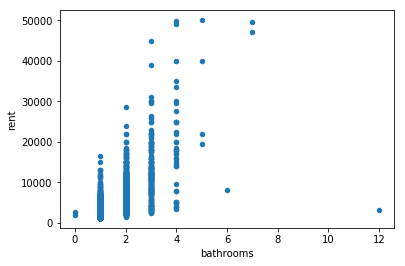

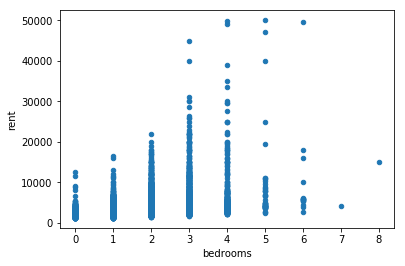

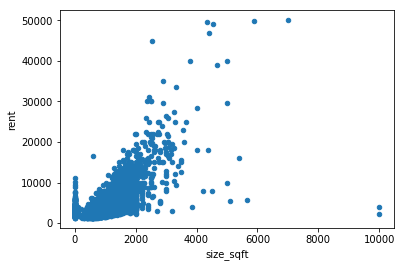

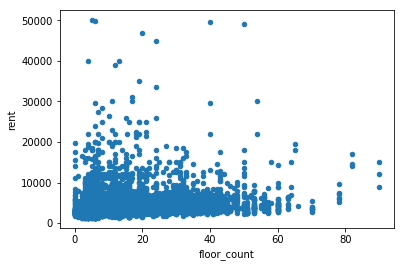

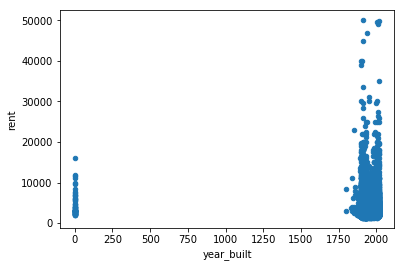

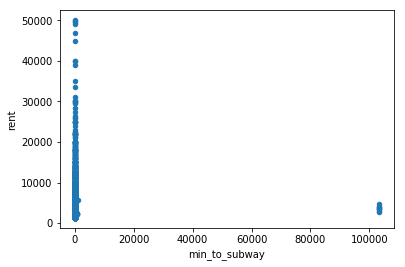

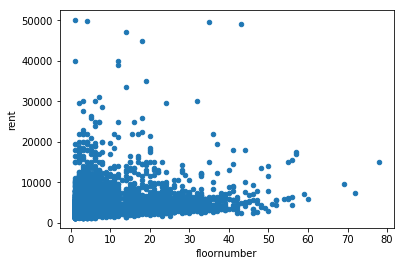

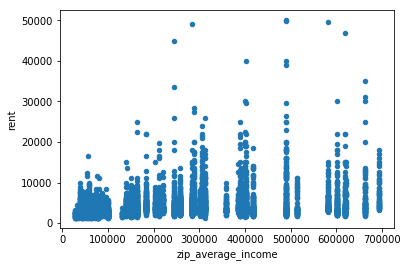

In [19]:
for feature in continuous_features:
    md_df.plot.scatter(feature, 'rent')

In [20]:
md_df.loc[md_df['size_sqft']==0].shape

(713, 39)

**drop size_sqrt = 0 for now, since there are 713 rows, might replace with mode when creating models**

In [21]:
def remove_outliers(md_df, feature, low_value, high_value):
    print(feature, ': ', md_df.shape)
    md_df = md_df[md_df[feature]>low_value]
    md_df = md_df[md_df[feature]<=high_value]
    md_df.reset_index(drop=True,inplace=True)
    print(feature, ': ', md_df.shape)
    return md_df

md_df = remove_outliers(md_df, 'bathrooms', 0, 12)
md_df = remove_outliers(md_df, 'size_sqft', 0, 10000)
md_df = remove_outliers(md_df, 'year_built', 1700, 2019)
md_df = remove_outliers(md_df, 'min_to_subway', 0, 60)
md_df = remove_outliers(md_df, 'floornumber', 0, 60)

md_df['year_built'] = 2019 - md_df['year_built'].astype(int)

bathrooms :  (10219, 39)
bathrooms :  (10217, 39)
size_sqft :  (10217, 39)
size_sqft :  (9505, 39)
year_built :  (9505, 39)
year_built :  (9447, 39)
min_to_subway :  (9447, 39)
min_to_subway :  (9435, 39)
floornumber :  (9435, 39)
floornumber :  (9432, 39)


### Encode categorical feature and drop useless features

In [22]:
boroughs = np.array(md_df['borough'].unique())

for borough in boroughs:
    md_df[borough] = md_df['borough'].apply(lambda x : int(x == borough))

features_notNeed = ['addr_unit', 'building_id', 'created_at', 'addr_street', 'addr_city', 'addr_zip', 'bin', 'bbl', 'description', \
                    'neighborhood', 'unit', 'borough', 'line']

md_df = md_df.drop(features_notNeed, axis=1)

### Use pair coorelation for continuous features

In [23]:
continuous_df = md_df[continuous_features+['rent']]
continuous_df.corr()['rent'][:-1]

bathrooms             0.655928
bedrooms              0.339703
size_sqft             0.696008
floor_count           0.262868
year_built           -0.116747
min_to_subway        -0.071222
floornumber           0.260490
zip_average_income    0.416449
Name: rent, dtype: float64

### Check coorelation for binary features

In [24]:
md_df[binary_features+['rent']].corr()['rent'][:-1]
coor_results= []

for feature in binary_features:
  df = raw_df.groupby([feature]).aggregate(['mean'])['rent']
  df[feature]= df.index
  coor_results.append(df.corr().iloc[0][1])
coor_df = pd.DataFrame({'Coorelation': coor_results,'Feature':binary_features})
coor_df


,Coorelation,Feature
0,1.0,has_doorman
1,1.0,has_elevator
2,1.0,has_fireplace
3,1.0,has_dishwasher
4,1.0,is_furnished
5,1.0,has_gym
6,1.0,allows_pets
7,1.0,has_washer_dryer
8,1.0,has_garage
9,1.0,has_roofdeck


As we can see in the correlation table, all binrary features highly affected the rents. When we build the models, we should include all binary features.

### Cleaning dataset test1
 Handle missing data
We frist find and count all the null values for test1 dataset

In [25]:
raw_test_df.isna().sum()

addr_unit                  19
building_id                 0
bedrooms                    0
bathrooms                   0
size_sqft                   0
created_at                  0
addr_street                 0
addr_city                   0
addr_zip                    0
addr_lat                    0
addr_lon                    0
bin                         0
bbl                         0
floor_count                 0
year_built                 67
min_to_subway              17
has_doorman                 0
has_elevator                0
has_fireplace               0
has_dishwasher              0
is_furnished                0
has_gym                     0
allows_pets                 0
has_washer_dryer            0
has_garage                  0
has_roofdeck                0
has_concierge               0
has_pool                    0
has_garden                  0
has_childrens_playroom      0
rent                        0
no_fee                      0
description                 1
neighborho

**we will be dropping the rows which we don't have values for year_built, min_to_subway, and floornumber, and then rename the dataframe as test_df**

In [26]:
test_df = raw_test_df.loc[
    raw_test_df.year_built.notnull() &
    raw_test_df.min_to_subway.notnull() & 
    raw_test_df.neighborhood.notnull() & 
    raw_test_df.floornumber.notnull()
]

print("original shape of dataset:",raw_test_df.shape)
print("shape of dataset after handling missing data:",test_df.shape)

original shape of dataset: (2000, 39)
shape of dataset after handling missing data: (1696, 39)


### Remove outliers of test dataset

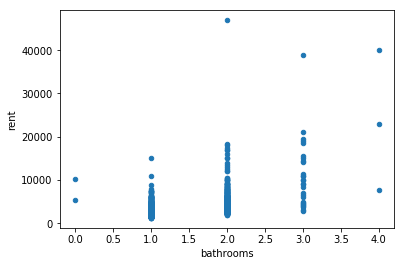

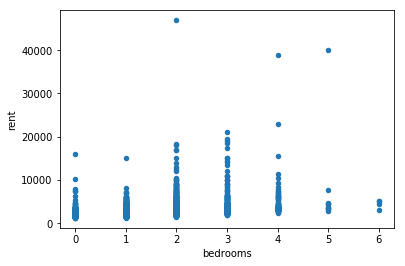

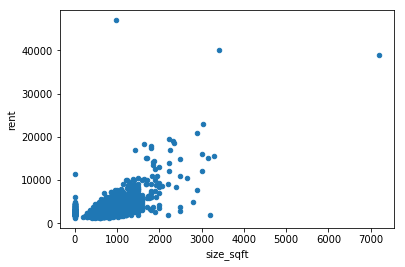

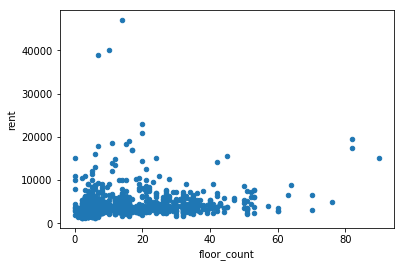

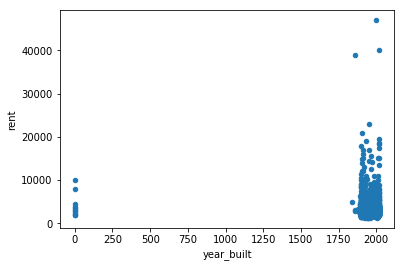

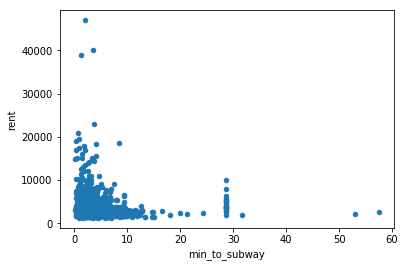

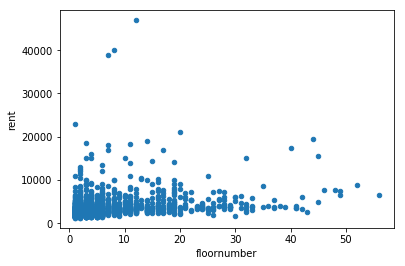

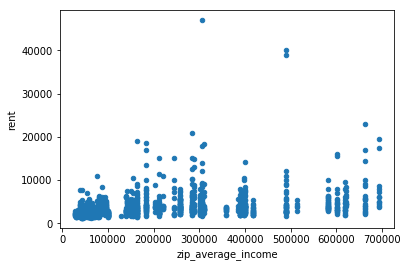

In [27]:
for feature in continuous_features:
    test_df.plot.scatter(feature, 'rent')

In [28]:
test_df = remove_outliers(test_df, 'bathrooms', 0, 12)
test_df = remove_outliers(test_df, 'bedrooms', 0, 12)
test_df = remove_outliers(test_df, 'size_sqft', 0, 10000)
test_df = remove_outliers(test_df, 'year_built', 1700, 2019)
test_df = remove_outliers(test_df, 'min_to_subway', 0, 60)
test_df = remove_outliers(test_df, 'floornumber', 0, 60)

test_df['year_built'] = 2019 - test_df['year_built'].astype(int)

bathrooms :  (1696, 39)
bathrooms :  (1694, 39)
bedrooms :  (1694, 39)
bedrooms :  (1464, 39)
size_sqft :  (1464, 39)
size_sqft :  (1334, 39)
year_built :  (1334, 39)
year_built :  (1325, 39)
min_to_subway :  (1325, 39)
min_to_subway :  (1325, 39)
floornumber :  (1325, 39)
floornumber :  (1325, 39)


**Encode categorical feature and drop useless features from test df**

In [29]:
boroughs = np.array(test_df['borough'].unique())

for borough in boroughs:
    test_df[borough] = test_df['borough'].apply(lambda x : int(x == borough))

features_notNeed = ['addr_unit', 'building_id', 'created_at', 'addr_street', 'addr_city', 'addr_zip', 'bin', 'bbl', 'description', \
                    'neighborhood', 'unit', 'borough', 'line']

test_df = test_df.drop(features_notNeed, axis=1)

# Modeling

We will be using cross validation to evaluate the performances of our all modles,and then deciding which should be the most suitable one, thus we will first create a function called get_cv_results to obtain the cv_performance.

In [30]:
md_df = shuffle(md_df).reset_index(drop=True)
test_df = shuffle(test_df).reset_index(drop=True)

In [31]:
features = list(md_df.columns)
features.remove('rent')
k_fold = KFold(n_splits=5)

In [32]:
def get_cv_results(regressor):
    
    results = []
    for train, test in k_fold.split(md_df):
        regressor.fit(md_df.loc[train, features], md_df.loc[train, 'rent'])
        y_predicted = regressor.predict(md_df.loc[test, features])
        accuracy = mean_squared_error(md_df.loc[test, 'rent'], y_predicted)**0.5
        results.append(accuracy)

    return np.mean(results), np.std(results)

## Random Forest

In [33]:
rforest = RandomForestRegressor(
    #random_state=random_state, 
    max_depth=5,
    n_estimators=100
)

rforest.fit(md_df[features], md_df['rent'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:
for feature,score in zip(features,rforest.feature_importances_):
    print(feature, ' ', score)

bedrooms   0.0037609556053723294
bathrooms   0.1435631466935625
size_sqft   0.6328545233252184
addr_lat   0.009444948269487887
addr_lon   0.008501100841605009
floor_count   0.003675229221092929
year_built   0.00531763975405032
min_to_subway   0.0013295153008360636
has_doorman   0.0009097697502733541
has_elevator   0.002091187033553041
has_fireplace   0.0009572975496408995
has_dishwasher   0.0006782143927214269
is_furnished   0.00034815756434045125
has_gym   0.002226613833538016
allows_pets   5.897336708446297e-05
has_washer_dryer   0.0006510636351962378
has_garage   9.117521494441078e-06
has_roofdeck   0.0033762663271449792
has_concierge   0.0007012290702768996
has_pool   0.0012141789400317048
has_garden   0.00037948681060117375
has_childrens_playroom   0.0002903518400390628
no_fee   0.0006161941426833295
floornumber   0.00862537613656602
zip_average_income   0.16365262205502226
Manhattan   0.003931409259645174
Brooklyn   0.0008351520707441232
Queens   2.7968817742215285e-07
Bronx   0.

## Gradient Boosting Regression
For the gradient boosting regressor we will first set up the hyperparameter max_depth=5 to avoid overfitting, will adjust more hyperparameter as we move on to improve the model

In [37]:
gbrdemo = GradientBoostingRegressor(
    max_depth=5,
    n_estimators=100
)

get_cv_results(gbrdemo)

(1058.3966882024079, 86.57818290005066)